# QR Damage Level Estimation (CNN)
Train a small CNN on a synthetic, class-balanced QR damage dataset. Class 0 is strictly pristine; higher classes apply increasingly strong, class-aware corruptions.

## Setup

In [1]:
!pip -q install qrcode[pil] opencv-python tqdm matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00


In [2]:
import os, csv, math, random
from pathlib import Path
from typing import Tuple, List
import numpy as np
import cv2
from PIL import Image
import qrcode
from qrcode.constants import ERROR_CORRECT_L, ERROR_CORRECT_M, ERROR_CORRECT_Q, ERROR_CORRECT_H

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data generation and loader
- Class 0: pristine (no corruption).
- Classes 1–4: class-aware corruption policy with strictly increasing strength.

In [3]:
# --- QR base image ---
def make_qr_pil(payload: str, version=None, error_correction=ERROR_CORRECT_M, box_size=10, border=4) -> Image.Image:
    qr = qrcode.QRCode(version=version, error_correction=error_correction, box_size=box_size, border=border)
    qr.add_data(payload)
    qr.make(fit=True)
    return qr.make_image(fill_color="black", back_color="white").convert("L")

def _to_uint8(img):
    return np.clip(img, 0, 255).astype(np.uint8)

# --- Class-aware corruption policy ---
def apply_corruptions_policy(img_u8: np.ndarray, severity: float, label: int, rng: np.random.Generator) -> np.ndarray:
    h, w = img_u8.shape[:2]
    img = img_u8.copy()
    s = float(max(0.0, min(1.0, severity)))
    if label == 0:
        return img  # strictly pristine

    # Blur (stronger with label)
    if rng.random() < 0.9:
        max_sigma = [0.0, 1.0, 2.0, 3.0, 4.0][label]
        sigma = s * max_sigma
        if sigma > 0.05:
            k = int(2 * round(3 * sigma) + 1)
            k = max(3, min(k, 31))
            img = cv2.GaussianBlur(img, (k, k), sigmaX=sigma, sigmaY=sigma)

    # Gaussian noise
    if rng.random() < 0.9:
        max_std = [0, 12, 24, 40, 60][label]
        std = s * max_std
        if std > 0:
            noise = rng.normal(0, std, size=img.shape).astype(np.float32)
            img = _to_uint8(img.astype(np.float32) + noise)

    # Salt & pepper (start at class 2)
    if label >= 2 and rng.random() < 0.6:
        max_amt = [0, 0, 0.02, 0.05, 0.10][label] * s
        num = int(max_amt * h * w)
        if num > 0:
            ys = rng.integers(0, h, size=num)
            xs = rng.integers(0, w, size=num)
            salt = rng.random(num) < 0.5
            img[ys[salt], xs[salt]] = 255
            img[ys[~salt], xs[~salt]] = 0

    # Random occlusions (none for class 1; grows with label)
    if label >= 2 and rng.random() < 0.8:
        max_area_frac = [0, 0, 0.06, 0.12, 0.25][label] * s
        nrect = rng.integers(1, [1,1,1,2,3][label] + 1)
        for _ in range(nrect):
            rect_area = max_area_frac * h * w / nrect
            if rect_area <= 1:
                continue
            rect_h = int(np.sqrt(rect_area) * (0.6 + 0.8 * rng.random()))
            rect_w = max(1, int(rect_area / max(1, rect_h)))
            if rect_h >= h or rect_w >= w:
                continue
            y0 = int(rng.integers(0, h - rect_h))
            x0 = int(rng.integers(0, w - rect_w))
            color = 0 if rng.random() < 0.5 else 255
            cv2.rectangle(img, (x0, y0), (x0 + rect_w, y0 + rect_h), color, thickness=-1)

    # Morphology (start at class 2)
    if label >= 2 and rng.random() < 0.7:
        kmax = [0, 0, 2, 3, 5][label]
        k = int(max(1, round(1 + s * kmax)))
        if k > 1:
            kernel = np.ones((k, k), np.uint8)
            if rng.random() < 0.5:
                img = cv2.erode(img, kernel, iterations=1)
            else:
                img = cv2.dilate(img, kernel, iterations=1)

    # Perspective warp (start at class 2)
    if label >= 2 and rng.random() < 0.6:
        max_disp = int([0, 0, 0.06, 0.10, 0.16][label] * s * min(h, w))
        if max_disp > 0:
            src = np.float32([[0,0],[w-1,0],[w-1,h-1],[0,h-1]])
            jitter = rng.integers(-max_disp, max_disp + 1, size=(4,2)).astype(np.float32)
            dst = src + jitter
            M = cv2.getPerspectiveTransform(src, dst)
            img = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)

    # JPEG artifacts (stronger at higher classes)
    if rng.random() < 0.7:
        q_min = [100, 90, 75, 55, 35][label]
        q = int(100 - (100 - q_min) * s)
        if q < 100:
            ok, enc = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), q])
            if ok:
                img = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

    # Brightness/contrast
    if rng.random() < 0.8:
        amax = [0.0, 0.2, 0.4, 0.6, 0.9][label]
        bmax = [0.0, 8.0, 16.0, 24.0, 36.0][label]
        alpha = 1.0 + amax * s * (rng.random() * 2 - 1)
        beta  = bmax * s * (rng.random() * 2 - 1)
        img = _to_uint8(alpha * img.astype(np.float32) + beta)

    return img

# --- Disk dataset generation ---
SEVERITY_RANGES = [
    (0.0, 0.0),   # class 0: pristine
    (0.05, 0.25), # class 1: mild
    (0.25, 0.50), # class 2: moderate
    (0.50, 0.75), # class 3: heavy
    (0.75, 1.00), # class 4: severe
]

def _random_payload(rng: np.random.Generator) -> str:
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-_"
    n = int(rng.integers(8, 128))
    return "".join(rng.choice(list(alphabet), size=n))

def _gen_one(img_size: int, rng: np.random.Generator):
    version = None
    ec = int(rng.choice([ERROR_CORRECT_L, ERROR_CORRECT_M, ERROR_CORRECT_Q, ERROR_CORRECT_H]))
    payload = _random_payload(rng)
    pil = make_qr_pil(payload, version=version, error_correction=ec)
    qr = np.array(pil)
    qr = cv2.resize(qr, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    # Sample class first to keep classes balanced
    label = int(rng.integers(0, 5))
    lo, hi = SEVERITY_RANGES[label]
    severity = float(lo if lo == hi else rng.uniform(lo, hi))
    img = apply_corruptions_policy(qr, severity, label, rng)
    return img, label, severity, ec, payload

def _ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def make_disk_dataset(out_dir: str, train_size=5000, val_size=1000, test_size=1000, img_size=160, seed=42, ext=".png"):
    out = Path(out_dir)
    _ensure_dir(out)

    def write_split(split: str, count: int, offset: int):
        split_dir = out / split
        for c in range(5):
            _ensure_dir(split_dir / str(c))
        csv_path = out / f"{split}_labels.csv"
        with open(csv_path, "w", newline="", encoding="utf-8") as fcsv:
            writer = csv.writer(fcsv)
            writer.writerow(["filename", "label", "severity", "error_correction", "payload"])
            for i in tqdm(range(count), desc=f"Generating {split}", ncols=100):
                rng = np.random.default_rng(seed + offset + i)
                img, label, severity, ec, payload = _gen_one(img_size, rng)
                fname = f"{split}_{i:06d}{ext}"
                fpath = split_dir / str(label) / fname
                if ext.lower() in [".jpg", ".jpeg"]:
                    cv2.imwrite(str(fpath), img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
                else:
                    cv2.imwrite(str(fpath), img)
                writer.writerow([fname, int(label), float(severity), int(ec), payload])

    write_split("train", train_size, 0)
    write_split("val",   val_size,   1_000_000)
    write_split("test",  test_size,  2_000_000)
    print(f"Dataset written to: {out.resolve()}")

# --- On-disk dataset loader ---
class QRDamageDiskDataset(Dataset):
    def __init__(self, root: str, split: str = "train", img_size: int = 160):
        self.root = Path(root)
        self.split = split
        self.img_size = img_size
        split_dir = self.root / split
        if not split_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {split_dir}")
        csv_path = self.root / f"{split}_labels.csv"
        self.samples: List[Tuple[Path, int]] = []
        if csv_path.exists():
            with open(csv_path, 'r', newline='', encoding='utf-8') as f:
                reader = csv.DictReader(f)
                for row in reader:
                    path = split_dir / row['label'] / row['filename']
                    label = int(row['label'])
                    if path.exists():
                        self.samples.append((path, label))
        else:
            for cls in sorted(p.name for p in split_dir.iterdir() if p.is_dir()):
                try:
                    label = int(cls)
                except ValueError:
                    continue
                for imgp in sorted((split_dir / cls).glob('*.*')):
                    if imgp.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp', '.webp'}:
                        self.samples.append((imgp, label))
        if len(self.samples) == 0:
            raise RuntimeError(f"No samples found in {split_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(str(path))
        if (img.shape[0], img.shape[1]) != (self.img_size, self.img_size):
            img = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)
        x = (img.astype(np.float32) / 255.0)[None, ...].repeat(3, axis=0)
        return torch.from_numpy(x), torch.tensor(label, dtype=torch.long)

def preview_grid_by_class(root: str, split: str = "train", img_size: int = 160, per_class: int = 8):
    root = Path(root) / split
    imgs, labels = [], []
    for cls in range(5):
        paths = sorted((root / str(cls)).glob('*.png'))[:per_class]
        for p in paths:
            im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if im is None:
                continue
            im = cv2.resize(im, (img_size, img_size), interpolation=cv2.INTER_AREA)
            imgs.append(im)
            labels.append(cls)
    if not imgs:
        print("No images to preview.")
        return
    rows, cols = 5, per_class
    pad = 4
    H, W = img_size, img_size
    canvas = np.full((rows*H + (rows+1)*pad, cols*W + (cols+1)*pad, 3), 255, np.uint8)
    for i, (im, cls) in enumerate(zip(imgs, labels)):
        r = cls
        c = i % per_class
        y0 = pad + r*(H+pad)
        x0 = pad + c*(W+pad)
        rgb = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
        if c == 0:
            cv2.putText(rgb, f"class {cls}", (5, 16), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
        canvas[y0:y0+H, x0:x0+W] = rgb
    plt.figure(figsize=(cols*1.6, rows*1.6))
    plt.imshow(canvas[..., ::-1])
    plt.axis('off')
    plt.show()

## Generate dataset

In [4]:
OUT_DIR = "data/qr_damage"
IMG_SIZE = 160
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 5000, 1000, 1000
SEED = 42
EXT = ".png"

make_disk_dataset(
    out_dir=OUT_DIR,
    train_size=TRAIN_SIZE,
    val_size=VAL_SIZE,
    test_size=TEST_SIZE,
    img_size=IMG_SIZE,
    seed=SEED,
    ext=EXT,
)

Generating test: 100%|██████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.91it/s]

Dataset written to: /content/data/qr_damage


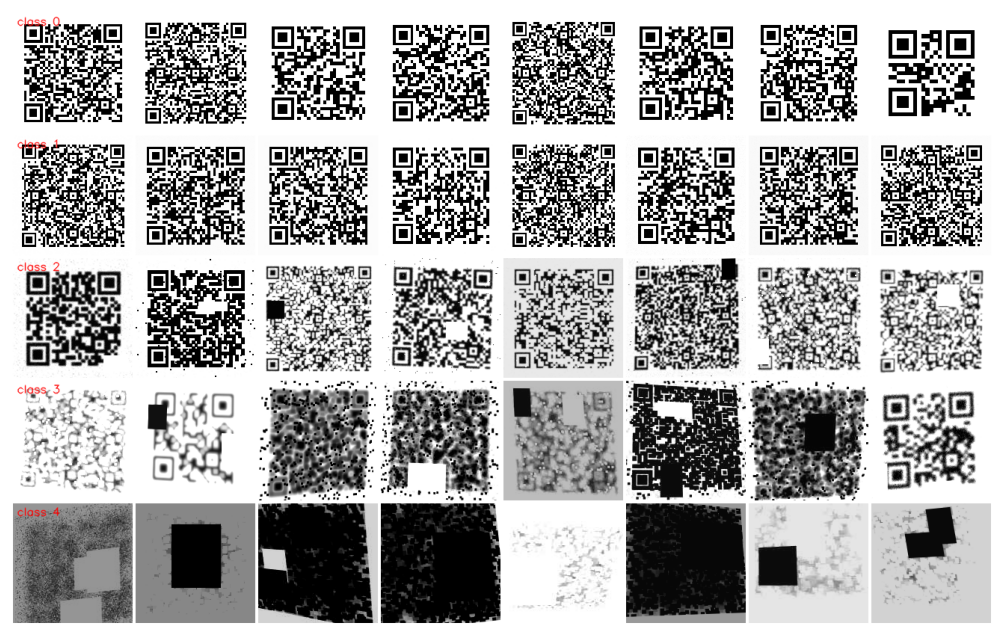

In [5]:
preview_grid_by_class(OUT_DIR, split="train", img_size=IMG_SIZE, per_class=8)

## Model

In [6]:
class TinyQRNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.head = nn.Linear(256, num_classes)
    def forward(self, x):
        z = self.features(x).flatten(1)
        return self.head(z)

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

## Train

In [7]:
BATCH_SIZE = 128
EPOCHS = 20
LR = 3e-4
OUTDIR = "runs"
os.makedirs(OUTDIR, exist_ok=True)

train_ds = QRDamageDiskDataset(root=OUT_DIR, split="train", img_size=IMG_SIZE)
val_ds   = QRDamageDiskDataset(root=OUT_DIR, split="val",   img_size=IMG_SIZE)
nw = max(2, min(4, os.cpu_count() or 2))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=nw, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=nw, pin_memory=True)

model = TinyQRNet(num_classes=5).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)

best_val = 0.0
for epoch in range(1, EPOCHS + 1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    tr_loss = tr_acc = n = 0
    for x, y in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        opt.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward(); opt.step()
        tr_loss += loss.item(); tr_acc += (logits.argmax(1)==y).float().mean().item(); n += 1
        if n % 10 == 0:
            pbar.set_postfix(loss=tr_loss/n, acc=tr_acc/n)

    model.eval()
    va_loss = va_acc = m = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            va_loss += F.cross_entropy(logits, y).item()
            va_acc  += (logits.argmax(1)==y).float().mean().item(); m += 1
    va_loss /= max(1, m); va_acc /= max(1, m)
    print(f"Val: loss={va_loss:.4f} acc={va_acc:.4f}")
    if va_acc > best_val:
        best_val = va_acc
        torch.save(model.state_dict(), os.path.join(OUTDIR, "best.pt"))
    torch.save(model.state_dict(), os.path.join(OUTDIR, "last.pt"))

print(f"Best val acc: {best_val:.4f}")

Epoch 1/20: 100%|██████████| 40/40 [00:12<00:00,  3.26it/s, acc=0.36, loss=1.37]


Val: loss=1.0962 acc=0.4151


Epoch 2/20: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s, acc=0.496, loss=0.972]


Val: loss=0.8000 acc=0.5357


Epoch 3/20: 100%|██████████| 40/40 [00:10<00:00,  3.71it/s, acc=0.589, loss=0.778]


Val: loss=0.7646 acc=0.5946


Epoch 4/20: 100%|██████████| 40/40 [00:10<00:00,  3.70it/s, acc=0.67, loss=0.633]


Val: loss=0.5727 acc=0.6963


Epoch 5/20: 100%|██████████| 40/40 [00:10<00:00,  3.67it/s, acc=0.722, loss=0.527]


Val: loss=1.6836 acc=0.4615


Epoch 6/20: 100%|██████████| 40/40 [00:10<00:00,  3.65it/s, acc=0.634, loss=0.748]


Val: loss=0.5295 acc=0.7306


Epoch 7/20: 100%|██████████| 40/40 [00:11<00:00,  3.61it/s, acc=0.739, loss=0.47]


Val: loss=0.4458 acc=0.7408


Epoch 8/20: 100%|██████████| 40/40 [00:11<00:00,  3.58it/s, acc=0.76, loss=0.435]


Val: loss=0.4455 acc=0.7255


Epoch 9/20: 100%|██████████| 40/40 [00:11<00:00,  3.55it/s, acc=0.771, loss=0.412]


Val: loss=0.4368 acc=0.7598


Epoch 10/20: 100%|██████████| 40/40 [00:11<00:00,  3.53it/s, acc=0.78, loss=0.401]


Val: loss=0.4008 acc=0.7886


Epoch 11/20: 100%|██████████| 40/40 [00:11<00:00,  3.57it/s, acc=0.776, loss=0.404]


Val: loss=0.4368 acc=0.7603


Epoch 12/20: 100%|██████████| 40/40 [00:11<00:00,  3.60it/s, acc=0.774, loss=0.414]


Val: loss=0.4146 acc=0.7375


Epoch 13/20: 100%|██████████| 40/40 [00:11<00:00,  3.60it/s, acc=0.762, loss=0.433]


Val: loss=0.4251 acc=0.7294


Epoch 14/20: 100%|██████████| 40/40 [00:11<00:00,  3.60it/s, acc=0.784, loss=0.384]


Val: loss=0.3889 acc=0.7713


Epoch 15/20: 100%|██████████| 40/40 [00:11<00:00,  3.58it/s, acc=0.8, loss=0.384]


Val: loss=2.2735 acc=0.4502


Epoch 16/20: 100%|██████████| 40/40 [00:11<00:00,  3.55it/s, acc=0.76, loss=0.489]


Val: loss=0.4230 acc=0.7243


Epoch 17/20: 100%|██████████| 40/40 [00:11<00:00,  3.52it/s, acc=0.786, loss=0.386]


Val: loss=0.3984 acc=0.7803


Epoch 18/20: 100%|██████████| 40/40 [00:11<00:00,  3.54it/s, acc=0.805, loss=0.365]


Val: loss=0.4033 acc=0.8025


Epoch 19/20: 100%|██████████| 40/40 [00:11<00:00,  3.55it/s, acc=0.819, loss=0.349]


Val: loss=0.3687 acc=0.8686


Epoch 20/20: 100%|██████████| 40/40 [00:11<00:00,  3.57it/s, acc=0.791, loss=0.375]


Val: loss=0.3565 acc=0.8640
Best val acc: 0.8686


## Evaluate

Testing: 100%|██████████| 8/8 [00:01<00:00,  7.98it/s]


Test accuracy: 0.8700


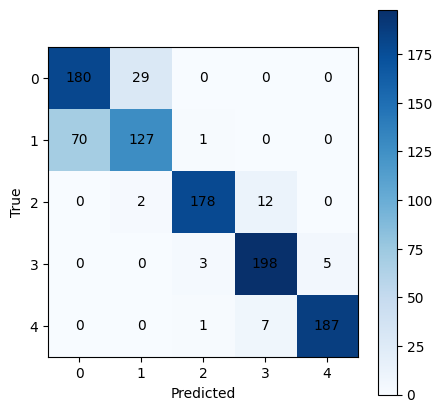

In [8]:
test_ds = QRDamageDiskDataset(root=OUT_DIR, split="test", img_size=IMG_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

model = TinyQRNet(num_classes=5).to(device)
ckpt_path = os.path.join(OUTDIR, "best.pt")
if os.path.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_labels.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds); all_labels = np.concatenate(all_labels)
test_acc = (all_preds == all_labels).mean()
print(f"Test accuracy: {test_acc:.4f}")

# Confusion matrix
cm = np.zeros((5,5), dtype=int)
for t, p in zip(all_labels, all_preds):
    cm[t, p] += 1
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(range(5)); plt.yticks(range(5))
for i in range(5):
    for j in range(5):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
plt.colorbar(); plt.show()

## Predict

In [9]:
CLASSES = ["clean", "mild", "moderate", "heavy", "severe"]

def preprocess(path, img_size=160):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    x = (img.astype(np.float32) / 255.0)[None, ...].repeat(3, axis=0)
    return torch.from_numpy(x[None, ...])  # 1x3xHxW

def predict_image(model_path: str, image_path: str, img_size: int = 160):
    model = TinyQRNet(num_classes=5).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    x = preprocess(image_path, img_size=img_size).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    pred = int(np.argmax(probs))
    print(f"Predicted: {pred} ({CLASSES[pred]})")
    print("Probabilities:", {CLASSES[i]: float(p) for i, p in enumerate(probs)})
    return pred, probs

print("Ready. Use predict_image(\"runs/best.pt\", \"path/to/image.png\").")

Ready. Use predict_image("runs/best.pt", "path/to/image.png").


In [16]:
try:
    from google.colab import files  # type: ignore
    uploaded = files.upload()
    for name in uploaded.keys():
        print("Running prediction for:", name)
        predict_image("runs/best.pt", name, img_size=IMG_SIZE)
except Exception as e:
    print("Uploader not available or error:", e)
    print("You can call predict_image(\"runs/best.pt\", \"/full/path/to/image.png\") manually.")

Saving test_000107.png to test_000107.png
Running prediction for: test_000107.png
Predicted: 1 (mild)
Probabilities: {'clean': 0.21901394426822662, 'mild': 0.722659707069397, 'moderate': 0.05610392242670059, 'heavy': 0.0007557567441836, 'severe': 0.001466637011617422}
